In [1]:
import sqlite3 #database
import os #general
import time #general
#$ pip install tqdm
from tqdm import tqdm #inline progress bar (quality of life)
import csv
#$ pip install numpy
import numpy as np
import math
#$ pip install matplotlib
from matplotlib import pyplot as plt
#$ pip install pandas
#import pandas #we ended up not needing this

In [2]:
#returns all the rows of the databse as a triplit (filename, code, comment)
def get_all_data(num_samples=10000):
    #start timer
    start = time.time()
    
    #connect to database
    pwd = os.getcwd()
    db_file = pwd+'/all_data.db'
    conn = sqlite3.connect(db_file)
    
    #get all the rows from the databse
    cur = conn.cursor()
    cur.execute("SELECT * FROM all_data")
    #changed from fetchall to sepecific number in order to work on machine
    #https://docs.python.org/3/library/sqlite3.html
    rows = cur.fetchmany(size=num_samples)
    #rows = cur.fetchall()
    
    #wrapp it up
    conn.close()
    end = time.time()
    print("Completed in %d seconds" % (end - start))
    
    return rows



def show_hist(data,ma,mi):
    bins = np.linspace(math.ceil(min(data)), 
                       math.floor(max(data)),
                       ma-mi) # fixed number of bins

    plt.xlim([min(data), max(data)])

    plt.hist(data, bins=bins, alpha=0.5)
    plt.title('Code Snippet length')
    plt.xlabel('Number of Lines')
    plt.ylabel('Number of Samples')

    plt.show()
    
    
def save_data(lang,code_sippets,comments,code_ma,text_ma):
    print('saving data for langauge',lang,'...')
    file_name = 'code-comment-'+str(lang)+'.csv'
    with open(file_name, 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['Code','Comment'])
        for c in range(len(code_snippets)):
            #raw
            writer.writerow([code_snippets[c],comments[c]])
            #clean
            #writer.writerow([clean(code_snippets[c]),clean(comments[c])])

#takes a dictionary and item for the purpose of counting number of items of that type
def dic_count(dic, item):
    if item in dic:
        dic[item] = dic[item]+1
    else:
        dic[item] = 1
    return dic
    
#returns the number of each extention in database
def get_extention_stats(rows):
    extention_count={}
    for row in tqdm(rows):
        filename = row[0]
        extention = filename.split('.')[-1]
        extention_count=dic_count(extention_count,extention)

    print(extention_count)

    
def get_python_pairs(rows):
    code_snippets = []
    comments = []
    too_big = 0
    for row in tqdm(rows):
        filename = row[0]
        extention = filename.split('.')[-1]
        if extention == 'py':
            #limit the size
            code_size = len(row[1])
            comment_size = len(row[2])
            if code_size<100 and code_size>10 and comment_size<100 and comment_size>10:
                code_snippets.append(row[1])
                comments.append(row[2])
            else:
                too_big+=1
    print('Total pairs:',len(comments))
    return code_snippets, comments


    print(extention_count)
    
def get_code_pairs(rows, lang, max_code_chars, max_text_chars, max_lines, min_lines):
    
    #loop through code pairs
    code_snippets = []
    comments = []
    data = []
    
    #for row in tqdm(rows[:100000]):
    for row in tqdm(rows):
        
        #check code type
        filename = row[0]
        extention = filename.split('.')[-1]
        if extention in lang:
            
            #limit the size
            code_size    = len(row[1])
            comment_size = len(row[2])
            num_lines    = row[1].count('\n')
            
            if code_size<max_code_chars and code_size>10:
                if comment_size<max_text_chars and comment_size>10:
                    if num_lines < max_lines and num_lines > min_lines:
                        
                        #why?
                        if '\0' not in row[1] and '\0' not in row[2]:
                            
                            #to compare semantic cohesion between code and comment
                            if False:
                                overlap = code_comment_cohesion(row[1], row[2])
                                common_len = len(overlap)
                                if '' in overlap:
                                    common_len-=1
                                
                                if common_len>=2:
                                    code_snippets.append(row[1])
                                    comments.append(row[2])
                            #get all pairs
                            else:
                                code_snippets.append(row[1])
                                comments.append(row[2])
                                
                            
                            '''
                            #to clean or not to clean
                            if True: #raw
                                code_snippets.append(row[1])
                                comments.append(row[2])
                            else: #cleaned
                                code_snippets.append(clean(row[1]))
                                comments.append(clean(row[2]))
                            #code_snippets.append(row[1].replace('\0',''))
                            #comments.append(row[2].replace(,''))
                            '''
                            
                            data.append(num_lines)

    print('Total pairs:',len(comments))
    #show_hist(data, max_lines, min_lines)
    return code_snippets, comments


In [3]:
import re
def clean(text):
    words = re.split(r'\W+', text)
    words = [word.lower() for word in words]
    words = ' '.join(words)
    words = words.replace('_',' ')
    
    
    #save operators
    #https://www.w3schools.com/python/python_operators.asp
    if False:
        ####
        #Three (3) CHARS
        ####
        
        #Assigment
        words = words.replace('//=','FloorDivision')
        words = words.replace('**=','FloorDivision')
        
        ####
        #TWO (2) CHARS
        ####
        
        #Python Comparison Operators
        words = words.replace('>','equal')
        words = words.replace('<','not equal')
        words = words.replace('>','greater than')
        words = words.replace('<','greater than or equal to')
        
        #### Arithmetic
        words = words.replace('**','exponentiation')
        words = words.replace('//','floor division')
        
        #### Python Bitwise Operators
        words = words.replace('<<','Zero fill left shift')
        words = words.replace('>>','Signed right shift')
        
        #### Assigment
        words = words.replace('+=','addition equals')
        words = words.replace('-=','subtraction equals')
        words = words.replace('*=','multiplication equals')
        words = words.replace('/=','division equals')
        words = words.replace('%=','modulus equals')
        words = words.replace('&=','and equals')
        words = words.replace('|=','or equals')
        words = words.replace('^=','xor equals')
        
        ####
        #One (1) char
        ####
        
        #?
        words = words.replace('.','dot')
        words = words.replace('_',' ')
        
        #Python Comparison Operators
        words = words.replace('>','greater than')
        words = words.replace('<','less than')
        
        #### Arithmetic
        words = words.replace('+','addition')
        words = words.replace('-','subtraction')
        words = words.replace('*','multiplication')
        words = words.replace('/','division')
        words = words.replace('%','modulus')
        
        #### Python Bitwise Operators
        words = words.replace('&','and')
        words = words.replace('|','or')
        words = words.replace('^','xor')
        words = words.replace('~','not')
        
        #### Assigment
        words = words.replace('=','equals')
    
    words = ''.join([i for i in words if i.isalpha() or i==' '])
    words = re.sub(' +', ' ', words)
    return words

In [3]:
#grab data from .db

In [5]:
rows = get_all_data(num_samples=1000000)
print('number of samples:',len(rows))

Completed in 3 seconds
number of samples: 1000000


In [ ]:
#make a list, and only keep ones with certain number of lines

In [6]:
#iterate through the rows and getting suitable information info
data=[]
max_lines = 20
min_lines = 3

#for row in rows[:100000]:
for row in tqdm(rows):
    filename = row[0]
    code = row[1]
    comment = row[2] 
    #print(code.count('\n'))
    if code.count('\n')>min_lines and code.count('\n')<max_lines+1:
        data.append(code.count('\n'))

100%|█████████████████████████████| 1000000/1000000 [00:03<00:00, 267107.02it/s]


Show # of line histogram of our preprocessed data


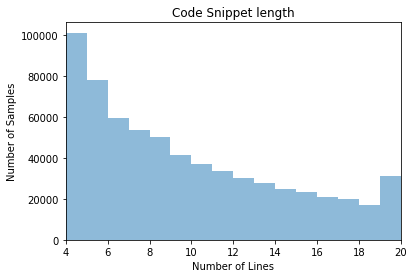

In [7]:
print('Show # of line histogram of our preprocessed data')
show_hist(data,max_lines,min_lines)

In [8]:
row

('xolox-python-humanfriendly-03d1db4/humanfriendly/tests.py',
 '    def test_generate_message(self):\n        \n        text = "Standard error generated by message()"\n        with CaptureOutput(merged=False) as capturer:\n            message(text)\n            self.assertEqual([], capturer.stdout.get_lines())\n            self.assertIn(text, self.ignore_coverage_warning(capturer))\n\n',
 'Test the :func:`humanfriendly.terminal.message()` function.')

In [ ]:
# GET PAIRS

In [8]:
max_code_chars = 100
max_text_chars = 100
lang=['py']
code_snippets, comments = get_code_pairs(rows, lang, max_code_chars, max_text_chars, max_lines, min_lines)

100%|█████████████████████████████| 1000000/1000000 [00:02<00:00, 382653.18it/s]

Total pairs: 73726


In [12]:
print(code_snippets[32])
print(comments[32])

    def run(self, func):
        
        with self:
            return func()


Run 'func' under os sandboxing


In [13]:
save_data('py', code_snippets, comments,  max_code_chars, max_text_chars) #all

saving data for langauge py ...


In [4]:
import ast
#import import_ipynb
#import Extract_Python_Pairs as EPP
#https://docs.python.org/3/library/tokenize.html
import tokenize
import io
import numpy as np
from tqdm import tqdm #inline progress bar (quality of life)
import collections


'''
ENDMARKER = 0
NAME = 1
NUMBER = 2
STRING = 3
NEWLINE = 4
INDENT = 5
DEDENT = 6
LPAR = 7
RPAR = 8
LSQB = 9
RSQB = 10
COLON = 11
COMMA = 12
SEMI = 13
PLUS = 14
MINUS = 15
STAR = 16
SLASH = 17
VBAR = 18
AMPER = 19
LESS = 20
GREATER = 21
EQUAL = 22
DOT = 23
PERCENT = 24
LBRACE = 25
RBRACE = 26
EQEQUAL = 27
NOTEQUAL = 28
LESSEQUAL = 29
GREATEREQUAL = 30
TILDE = 31
CIRCUMFLEX = 32
LEFTSHIFT = 33
RIGHTSHIFT = 34
DOUBLESTAR = 35
PLUSEQUAL = 36
MINEQUAL = 37
STAREQUAL = 38
SLASHEQUAL = 39
PERCENTEQUAL = 40
AMPEREQUAL = 41
VBAREQUAL = 42
CIRCUMFLEXEQUAL = 43
LEFTSHIFTEQUAL = 44
RIGHTSHIFTEQUAL = 45
DOUBLESTAREQUAL = 46
DOUBLESLASH = 47
DOUBLESLASHEQUAL = 48
AT = 49
ATEQUAL = 50
RARROW = 51
ELLIPSIS = 52
COLONEQUAL = 53
OP = 54
AWAIT = 55
ASYNC = 56
TYPE_IGNORE = 57
TYPE_COMMENT = 58
# These aren't used by the C tokenizer but are needed for tokenize.py
ERRORTOKEN = 59
COMMENT = 60
NL = 61
ENCODING = 62
N_TOKENS = 63
# Special definitions for cooperation with parser
NT_OFFSET = 256
'''


key_words = ['False','await','else','import','pass',
            'None','break','except','in','raise',
            'True','class','finally','is','return',
            'and','continue','for','lambda','try',
            'as','def','from','nonlocal','while',
            'assert','del','global','not','with',
            'async','elif','if','or','yield']

#https://docs.python.org/3/library/tokenize.html
def get_vars(code_snippet):
    tokens = tokenize.tokenize(io.BytesIO(code_snippet.encode('utf-8')).readline)
    
    #for keeping track of variables
    variables = []
    try: #for issues with tokenizing
        for token in tokens:

            if token.type not in [0,57,58,59,60,61,62,63,256]:



                #keyword or variable
                if token.type == 1:
                    variables.append(token.string)
                    #avoidkey word
                    #if token.string not in key_words:
                    #    variables.append(token.string)

                #string
                elif token.type == 3:
                    variables.append(token.string)

        return variables
    
    except:
        return []
import re
def clean_comment(text):
    words = re.split(r'\W+', text)
    words = [word.lower() for word in words]
    words = ' '.join(words)
    words = ''.join([i for i in words if i.isalpha() or i==' '])
    words = re.sub(' +', ' ', words)
    
    return words

def clean_vars(var_list):
    clean_var_list =  ' '.join(var_list)
    clean_var_list =  clean_var_list.replace('_',' ')
    clean_var_list = clean_var_list.split(' ')
    return clean_var_list

# Python program to illustrate the intersection
# of two lists using set() method
def intersection(lst1, lst2):
    return list(set(lst1) & set(lst2))

def code_comment_cohesion(code, comment):
    code_vars = get_vars(code)
    clean_var_list = clean_vars(code_vars)
    words = clean_comment(comment).split(' ')
    shared_words = intersection(words, clean_var_list)
    return shared_words

In [15]:
num_samples = 20#len(code_snippets)
print(num_samples)
show=True
required_overlap=2

valid_counter=0
for i in tqdm(range(num_samples)):
    pass
    code_vars = get_vars(code_snippets[i])
    clean_var_list = clean_vars(code_vars)
    words = clean(comments[i]).split(' ')
    
    #show all pairs
    #print('-----'*8)
    #print(words)
    #print(clean_var_list)
    #print(intersection(words, clean_var_list))
    common = intersection(words, clean_var_list)
    common_len = len(common)
    if '' in common:
        common_len-=1
    if common_len>=required_overlap:
        valid_counter+=1
        if show:
            #show pairs that are valid
            print('##########'*3)
            print(code_snippets[i])
            print(comments[i])
            print(common)
print('number valid',valid_counter)
print('percent valid:',valid_counter/num_samples)

20


100%|█████████████████████████████████████████| 20/20 [00:00<00:00, 2073.10it/s]

##############################
    def current_search_path(self):
        
        return os.environ.get('PATH', os.defpath)



The value of ``$PATH`` or :data:`os.defpath` (a string).
['defpath', 'path', 'os']
##############################
    def current_style(self):
        
        return self.stack[-1] if self.stack else {}


Get the current style from the top of the stack (a dictionary).
['stack', 'style', 'current']
##############################
    def run_cli_raise_other(self):
        
        raise ValueError()


run_cli() sample that raises an exception.
['cli', 'run']
##############################
    def rounded(self):
        
        return format_timespan(round(self.elapsed_time))


Human readable timespan rounded to seconds (a string).
['timespan', 'rounded']
##############################
    def __str__(self):
        
        return format_timespan(self.elapsed_time)



Show the elapsed time since the :class:`Timer` was created.
['', 'elapsed', 'time']
#########

| # shared vocab | # valid pairs | % of original |
| --- | --- | --- |
| 1 | 53,248 | 72.22 |
| 2 | 29,234 | 39.65 |
| 3 | 11,122 | 15.09 |
| 4 | 2,979 | 4.04 |
| 5 | 705 | 0.95 |

original dataset consists of 73726 comment pairs

Completed in 2 seconds
number of samples: 1000000


100%|█████████████████████████████| 1000000/1000000 [00:02<00:00, 385760.78it/s]


Show # of line histogram of our preprocessed data


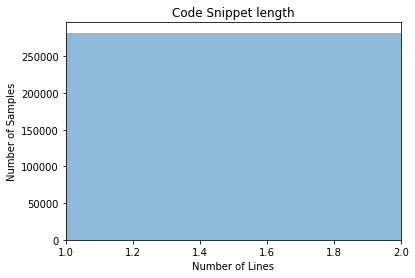

100%|████████████████████████████| 1000000/1000000 [00:00<00:00, 1359977.54it/s]

Total pairs: 1654
saving data for langauge py ...


"\n#individual languages\nfor lang in [Python,CPP,JAVA]:\n    code_snippets, comments = get_code_pairs(rows, lang, max_code_chars, max_text_chars, max_lines, min_lines)\n    save_data('short_'+lang[0], code_snippets, comments,  max_code_chars, max_text_chars)\n\n    \n#multiple languagse\ncode_snippets, comments = get_code_pairs(rows, multi, max_code_chars, max_text_chars, max_lines, min_lines)\nsave_data('short_all', code_snippets, comments,  max_code_chars, max_text_chars) #all\n"

In [4]:
51892#short 0-5


rows = get_all_data(num_samples=1000000)
print('number of samples:',len(rows))



#iterate through the rows and getting suitable information info
data=[]
max_lines = 2
min_lines = 0

#for row in rows[:100000]:
for row in tqdm(rows):
    filename = row[0]
    code = row[1]
    comment = row[2] 
    #print(code.count('\n'))
    if code.count('\n')>min_lines and code.count('\n')<max_lines+1:
        data.append(code.count('\n'))
        

print('Show # of line histogram of our preprocessed data')
show_hist(data,max_lines,min_lines)


Python = ['py']
CPP    = ['cpp','h']
JAVA   = ['java']
multi  = Python # + CPP + JAVA

max_code_chars = 100
max_text_chars = 100

#just python
code_snippets, comments = get_code_pairs(rows, multi, max_code_chars, max_text_chars, max_lines, min_lines)
save_data('py', code_snippets, comments,  max_code_chars, max_text_chars) #all

'''
#individual languages
for lang in [Python,CPP,JAVA]:
    code_snippets, comments = get_code_pairs(rows, lang, max_code_chars, max_text_chars, max_lines, min_lines)
    save_data('short_'+lang[0], code_snippets, comments,  max_code_chars, max_text_chars)

    
#multiple languagse
code_snippets, comments = get_code_pairs(rows, multi, max_code_chars, max_text_chars, max_lines, min_lines)
save_data('short_all', code_snippets, comments,  max_code_chars, max_text_chars) #all
'''

Completed in 0 seconds
number of samples: 10000


100%|█████████████████████████████████| 10000/10000 [00:00<00:00, 357010.66it/s]

Show # of line histogram of our preprocessed data


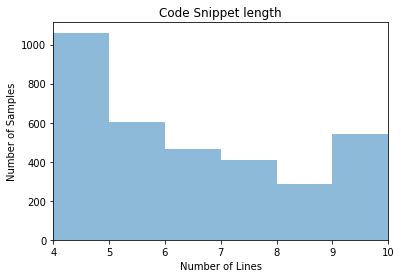

100%|████████████████████████████████| 10000/10000 [00:00<00:00, 1240404.57it/s]


Total pairs: 449
saving data for langauge medium_py ...


100%|████████████████████████████████| 10000/10000 [00:00<00:00, 1043047.85it/s]


Total pairs: 523
saving data for langauge medium_cpp ...


100%|█████████████████████████████████| 10000/10000 [00:00<00:00, 721327.67it/s]


Total pairs: 729
saving data for langauge medium_java ...


100%|█████████████████████████████████| 10000/10000 [00:00<00:00, 527751.37it/s]

Total pairs: 1701
saving data for langauge medium_all ...


In [3]:
#med 3-10

rows = get_all_data(num_samples=10000)
print('number of samples:',len(rows))



#iterate through the rows and getting suitable information info
data=[]
max_lines = 10
min_lines = 3

#for row in rows[:100000]:
for row in tqdm(rows):
    filename = row[0]
    code = row[1]
    comment = row[2] 
    #print(code.count('\n'))
    if code.count('\n')>min_lines and code.count('\n')<max_lines+1:
        data.append(code.count('\n'))
        

print('Show # of line histogram of our preprocessed data')
show_hist(data,max_lines,min_lines)


Python = ['py']
CPP    = ['cpp','h']
JAVA   = ['java']
multi  = Python + CPP + JAVA

max_code_chars = 500
max_text_chars = 250

#just python
#code_snippets, comments = get_code_pairs(rows, multi, max_code_chars, max_text_chars, max_lines, min_lines)
#save_data('py', code_snippets, comments,  max_code_chars, max_text_chars) #all

#'''
#individual languages
for lang in [Python,CPP,JAVA]:
    code_snippets, comments = get_code_pairs(rows, lang, max_code_chars, max_text_chars, max_lines, min_lines)
    save_data('medium_'+lang[0], code_snippets, comments,  max_code_chars, max_text_chars)

    
#multiple languagse
code_snippets, comments = get_code_pairs(rows, multi, max_code_chars, max_text_chars, max_lines, min_lines)
save_data('medium_all', code_snippets, comments,  max_code_chars, max_text_chars) #all
#'''

  0%|          | 24073/16115540 [00:00<01:06, 240723.34it/s]

Completed in 167 seconds
number of samples: 16115540


100%|██████████| 16115540/16115540 [01:15<00:00, 212733.53it/s]


Show # of line histogram of our preprocessed data


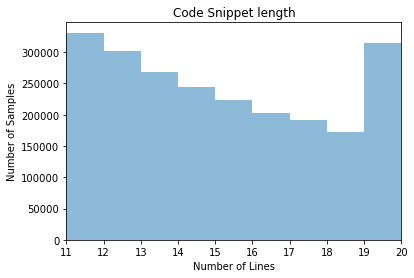

100%|██████████| 16115540/16115540 [00:22<00:00, 719013.15it/s]


Total pairs: 798480
saving data for langauge py ...


"\n#individual languages\nfor lang in [Python,CPP,JAVA]:\n    code_snippets, comments = get_code_pairs(rows, lang, max_code_chars, max_text_chars, max_lines, min_lines)\n    save_data('long_'+lang[0], code_snippets, comments,  max_code_chars, max_text_chars)\n\n    \n#multiple languagse\ncode_snippets, comments = get_code_pairs(rows, multi, max_code_chars, max_text_chars, max_lines, min_lines)\nsave_data('long_all', code_snippets, comments,  max_code_chars, max_text_chars) #all\n"

In [3]:
#long 10-20

rows = get_all_data()
print('number of samples:',len(rows))



#iterate through the rows and getting suitable information info
data=[]
max_lines = 20
min_lines = 10

#for row in rows[:100000]:
for row in tqdm(rows):
    filename = row[0]
    code = row[1]
    comment = row[2] 
    #print(code.count('\n'))
    if code.count('\n')>min_lines and code.count('\n')<max_lines+1:
        data.append(code.count('\n'))
        

print('Show # of line histogram of our preprocessed data')
show_hist(data,max_lines,min_lines)


Python = ['py']
CPP    = ['cpp','h']
JAVA   = ['java']
multi  = Python + CPP + JAVA

max_code_chars = 500
max_text_chars = 250

#just python
code_snippets, comments = get_code_pairs(rows, multi, max_code_chars, max_text_chars, max_lines, min_lines)
save_data('py', code_snippets, comments,  max_code_chars, max_text_chars) #all

'''
#individual languages
for lang in [Python,CPP,JAVA]:
    code_snippets, comments = get_code_pairs(rows, lang, max_code_chars, max_text_chars, max_lines, min_lines)
    save_data('long_'+lang[0], code_snippets, comments,  max_code_chars, max_text_chars)

    
#multiple languagse
code_snippets, comments = get_code_pairs(rows, multi, max_code_chars, max_text_chars, max_lines, min_lines)
save_data('long_all', code_snippets, comments,  max_code_chars, max_text_chars) #all
'''

In [17]:
#get all extention types
'''
types=[]
for row in tqdm(rows[:1000000]):
    types.append(row[0].split('.')[-1])
for t in set(types):
    print(t,types.count(t))
    
'''

#example of how ot iterate through the rows and getting info
'''
for row in rows[:100]:
    filename = row[0]
    code = row[1]
    comment = row[2]  
'''

"\ntypes=[]\nfor row in tqdm(rows[:1000000]):\n    types.append(row[0].split('.')[-1])\nfor t in set(types):\n    print(t,types.count(t))\n    \n"